In [1]:
import matplotlib.pyplot as plt
import numpy as np
from optix import *

def custom_str_repr(gb: GaussianBeam) -> str:
    return f"""
    waist_loc\t=\t{gb.waist_location*10**2} cm
    waist_rad\t=\t{gb.waist_radius*10**3} mm
    ray_range\t=\t{gb.rayleigh_range*10**3} mm
    divergence\t=\t{gb.divergence*10**3} mrad
    """
GaussianBeam.__str__ = custom_str_repr

# Gaussovský svazek na výstupu z vlákna
Vlákno je označeno OE-000592. Bohužel na stránce TOPTICY žádné takové nanabízejí. Proto počítám se sepcifikami vláken https://www.toptica.com/products/optical-isolators-photonicals/photonicals/optical-fibers.

Pro získání Rayleigho vzdálenosti využit vzorec https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=14204


    waist_loc	=	0 cm
    waist_rad	=	0.0017500000000000003 mm
    ray_range	=	0.023755870374367265 mm
    divergence	=	73.66600223110582 mrad
    


Text(0, 0.5, 'Beam diameter [mm]')

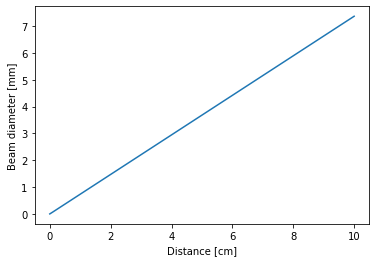

In [2]:
MFD = 3.5e-6
NA = 0.07
WAVE_LENGTH = 405e-9
zr = math.pi / WAVE_LENGTH * (MFD / 2)**2   
fiber_out = GaussianBeam(WAVE_LENGTH, zr=zr)
print(fiber_out)


z = np.linspace(0, 0.1, 100)
w = fiber_out.beam_radius(z)
plt.plot(z*10**2, w*10**3)
plt.xlabel("Distance [cm]")
plt.ylabel("Beam diameter [mm]")


# Šíření svazku krystalem
Předpoklad šíření podél osy $x$ přičemž čerpání je polarizováno horizontálně podél osy $y$. Posléze se generuje horizontální ($x$) a vertikální ($z$) fotony. Krystal od firmy Raicol má dimenze $1\times1\times2 mm$ a periodu pĺování $\Lambda = 10.025 \mu m$. Krystal KTP je dvojosý materiál s index lomu podél krystalografický os ($\lambda$ je v $\mu m$)
    $$ 
        n_x^2 = 3.29100 + \frac{0.04140}{\lambda^2 - 0.03978} + \frac{9.35522}{\lambda^2 - 31.45571} \\
        n_y^2 = 3.45018 + \frac{0.04341}{\lambda^2 - 0.04597} + \frac{16.98825}{\lambda^2 - 39.43799} \\
        n_z^2 = 4.59423 + \frac{0.06206}{\lambda^2 - 0.04763} + \frac{110.80672}{\lambda^2 - 86.12171}
    $$


Dle https://journals.aps.org/pra/abstract/10.1103/PhysRevA.81.053805 dochází k nejoptimálnější generaci SPDC při hodnotě kofokálního parametru $\xi_s \approx \xi_i \approx \xi_p \approx 2.84$. Přičemž platí, že 
    $$\xi_j = \frac{L}{k_j w_j^2},$$
kde $L$ je délka krystalu, $k_j$ je odpovídající vlnové číslo a $w_j$ je velikost krčku Gaussovského svazku. Tedy podmínka na velikost krčku je 
    $$w_j = \sqrt{\frac{L}{k_j \xi_j}} \approx \sqrt{\frac{L}{2.84 \cdot k_j }}, \quad k_j = \frac{\omega_j}{c} \cdot n_j(\omega_j).$$


In [3]:
LIGHT_SPEED = 299_792_458
def KRP_n_x(wl) -> float:
    return math.sqrt(3.29100 + 0.04140 / (wl**2 - 0.03978) + 9.35522 / (wl**2 - 31.45571))

def KRP_n_y(wl) -> float:
    return math.sqrt(3.45018 + 0.04341 / (wl**2 - 0.04597) + 16.98825 / (wl**2 - 39.43799))

def KRP_n_z(wl) -> float:
    return math.sqrt(4.59423 + 0.06206 / (wl**2 - 0.04763) + 110.80672 / (wl**2 - 86.12171))

def to_freq(wl) -> float:
    """Converts wavelength to angular frequency"""
    return 2 * math.pi * LIGHT_SPEED / wl

def to_wavelength(freq) -> float:
    """Converts angular frequency to wavelength"""
    return 2 * math.pi * LIGHT_SPEED / freq

In [21]:
L = 2e-3 # 2cm krystal od Raicolu
FOCAL_PARAM = 2.84 #optimum 2.84

n_p = KRP_n_y(WAVE_LENGTH*10**(-3)) # Pump je horizontálne polarizovaný, vkládám v mikrometrech
n_s = KRP_n_y(WAVE_LENGTH*10**(-3)*2)
n_i = KRP_n_z(WAVE_LENGTH*10**(-3)*2)

omega_p = to_freq(WAVE_LENGTH)
omega_s = to_freq(WAVE_LENGTH * 2)
omega_i = to_freq(WAVE_LENGTH * 2)

k_p = omega_p / LIGHT_SPEED * n_p
k_s = omega_s / LIGHT_SPEED * n_s
k_i = omega_i / LIGHT_SPEED * n_i

w_p = math.sqrt(L / (FOCAL_PARAM * k_p))
w_s = math.sqrt(L / (FOCAL_PARAM * k_s))
w_i = math.sqrt(L / (FOCAL_PARAM * k_i))

focus_info = f"""
    n_p: {n_p}, omega_p: {omega_p}s^-1, k_p: {k_p}m^-1, w_p: {w_p*10**6} um
    n_s: {n_s}, omega_s: {omega_s}s^-1, k_s: {k_s}m^-1, w_s: {w_s*10**6} um
    n_i: {n_i}, omega_i: {omega_i}s^-1, k_i: {k_i}m^-1, w_i: {w_i*10**6} um
"""
print(f"Optimal focus in crystal of length {L*10**3}mm:")
print(focus_info)

Optimal focus in crystal of length 2.0mm:

    n_p: 1.4405242023903018, omega_p: 4650991524219391.0s^-1, k_p: 22348346.921223056m^-1, w_p: 5.613492226620463 um
    n_s: 1.4405242023903018, omega_s: 2325495762109695.5s^-1, k_s: 11174173.460611528m^-1, w_s: 7.938676839162602 um
    n_i: 1.4158532155790764, omega_i: 2325495762109695.5s^-1, k_i: 10982800.149690649m^-1, w_i: 8.007543144756472 um



# Propagace systémem

In [24]:
# Kontrolní olomoucký systém
gauss_in = fiber_out
op = OpticalPath()

op.append(FreeSpace(10e-3))
op.append(ThinLens(10e-3))

op.append(FreeSpace(249e-3))
op.append(ThinLens(175e-3))
op.append(FreeSpace(284.1e-3))

# op.append(PlanarBoundary(n_p))
# op.append(PropagationInMedia(1e-3, n_p))

gauss_out = op.propagate(gauss_in)

print(op.length)
print(gauss_out)



0.5431

    waist_loc	=	43.4110585347669 cm
    waist_rad	=	0.030621461064400068 mm
    ray_range	=	7.27355398939188 mm
    divergence	=	4.209972333890689 mrad
    


In [14]:
def propagate_in_system(d1, f, d2) -> tuple[GaussianBeam, float]:
    """
    System with fixed colimation lens, though variable --d1-->(f)--d2-->. 
    
    Returns output GaussianBeam and length of the optical path
    """
    gauss_in = fiber_out
    op = OpticalPath()
    
    # Kolimace
    op.append(FreeSpace(d=4.9e-2))                              # <--- Kolimační vzdálenost
    # op.append(PlanoConvexLens(R=18e-3, n=1.5168, d=7e-3))     # <--- Kolimační čočka (Thorlabs LA1027-A, 35mm)
    op.append(PlanoConvexLens(R=25.8e-3, n=1.5168, d=5.3e-3))   # <--- Kolimační čočka (ThorLabs LA1131-A, 50mm)
    
    # Fokusace do krystalu
    op.append(FreeSpace(d1))                                # <--- STUPEŇ VOLNOST #1                                     
    op.append(ThinLens(f))                                  # <--- Fokusační čočka (150mm)
    op.append(FreeSpace(d2))                                # <--- STUPEŇ VOLNOST #2   

    # Vstupuje do krystalu
    op.append(PlanarBoundary(n_p))                          
    op.append(PropagationInMedia(L/2, n_p))

    gauss_out = op.propagate(gauss_in)
    length_out = op.length
    del op
    return gauss_out, length_out

In [15]:
# Optimization 
from scipy.optimize import minimize, root
def optimization_function(d: tuple[float, float]) -> tuple[float, float]:
    gauss_out, length = propagate_in_system(d[0], 175e-3, d[1])
    return gauss_out.waist_radius - w_p, length - gauss_out.waist_location

o = root(optimization_function, [1, 1])
print(o)

    fjac: array([[-3.01317328e-04, -9.99999955e-01],
       [ 9.99999955e-01, -3.01317328e-04]])
     fun: array([1.35525272e-20, 1.11022302e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.78026491e-11,  3.21987910e-18])
       r: array([-1.86266810e-02, -1.43705591e+00, -4.34056714e-04])
  status: 1
 success: True
       x: array([0.49095497, 0.1546144 ])
